In [ ]:
!pip install torchmetrics scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_fscore_support, roc_curve,
                             auc, accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Update path to match your folder structure
BASE_PATH = '/content/drive/MyDrive/pokeproject/pokemon_data'
CSV_PATH = f'{BASE_PATH}/pokemon.csv'
IMAGES_PATH = f'{BASE_PATH}/images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#old

In [ ]:
class PokemonDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Name']
        # Try different extensions
        img_path = None
        for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG']:
            temp_path = os.path.join(self.img_dir, f"{img_name}{ext}")
            if os.path.exists(temp_path):
                img_path = temp_path
                break

        if img_path is None:
            raise FileNotFoundError(f"Image not found for {img_name}")

        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Type1_encoded']

        if self.transform:
            image = self.transform(image)

        return image, label

# Load CSV
df = pd.read_csv(CSV_PATH)
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:\n{df.head()}")

# Use only primary type
df_filtered = df[['Name', 'Type1']].copy()

# Check class distribution
print(f"\nType distribution:\n{df_filtered['Type1'].value_counts()}")

# Remove classes with less than 10 members (flying group removed)
type_counts = df_filtered['Type1'].value_counts()
valid_types = type_counts[type_counts >= 10].index
df_filtered = df_filtered[df_filtered['Type1'].isin(valid_types)].copy()

print(f"\nFiltered dataset shape: {df_filtered.shape}")
print(f"\nFiltered type distribution:\n{df_filtered['Type1'].value_counts()}")

# Encode types
type_mapping = {type_: idx for idx, type_ in enumerate(df_filtered['Type1'].unique())}
df_filtered['Type1_encoded'] = df_filtered['Type1'].map(type_mapping)

print(f"\nNumber of classes: {len(type_mapping)}")

# Split data
train_df, temp_df = train_test_split(df_filtered, test_size=0.3,
                                      stratify=df_filtered['Type1_encoded'],
                                      random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5,
                                    stratify=temp_df['Type1_encoded'],
                                    random_state=42)

print(f"\nTrain: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Dataset shape: (809, 4)

First few rows:
         Name  Type1   Type2   Evolution
0   bulbasaur  Grass  Poison     ivysaur
1     ivysaur  Grass  Poison    venusaur
2    venusaur  Grass  Poison         NaN
3  charmander   Fire     NaN  charmeleon
4  charmeleon   Fire     NaN   charizard

Type distribution:
Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Dark         29
Fighting     29
Dragon       27
Ghost        27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: count, dtype: int64

Filtered dataset shape: (806, 2)

Filtered type distribution:
Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Name: count, dtype: int64

Numbe

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = PokemonDataset(train_df, IMAGES_PATH, train_transform)
val_dataset = PokemonDataset(val_df, IMAGES_PATH, test_transform)
test_dataset = PokemonDataset(test_df, IMAGES_PATH, test_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(type_mapping)
print(f"Number of classes: {num_classes}")

Number of classes: 17


In [ ]:
class BaselineCNN(nn.Module):
    """Simple 3-layer CNN as baseline model"""
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()

        # Convolutional blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [ ]:
class AlexNetCustom(nn.Module):
    """AlexNet architecture - ILSVRC 2012 Winner"""
    def __init__(self, num_classes):
        super(AlexNetCustom, self).__init__()

        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Calculate the correct input size for FC layer
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
class VGG16Custom(nn.Module):
    """VGG16 architecture - ILSVRC 2014 Winner"""
    def __init__(self, num_classes):
        super(VGG16Custom, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
class BasicBlock(nn.Module):
    """Basic ResNet building block"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

class ResNet18Custom(nn.Module):
    """ResNet18 architecture - Based on ILSVRC 2015 Winner"""
    def __init__(self, num_classes):
        super(ResNet18Custom, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
class InceptionModule(nn.Module):
    """Inception module for GoogLeNet"""
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()

        # 1x1 convolution branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        # 1x1 -> 3x3 convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # 1x1 -> 5x5 convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )

        # 3x3 pool -> 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)

class GoogLeNetCustom(nn.Module):
    """GoogLeNet/Inception architecture - ILSVRC 2014 Winner"""
    def __init__(self, num_classes):
        super(GoogLeNetCustom, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [ ]:
class DenseLayer(nn.Module):
    """Dense layer for DenseNet"""
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)

        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(out)))
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    """Dense block containing multiple dense layers"""
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

class Transition(nn.Module):
    """Transition layer between dense blocks"""
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        out = self.pool(out)
        return out

class DenseNet121Custom(nn.Module):
    """DenseNet-121 architecture - Widely adopted post-ILSVRC model"""
    def __init__(self, num_classes, growth_rate=32, block_config=(6, 12, 24, 16)):
        super(DenseNet121Custom, self).__init__()

        # Initial convolution
        num_init_features = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Dense blocks
        num_features = num_init_features

        # Block 1
        self.block1 = DenseBlock(block_config[0], num_features, growth_rate)
        num_features = num_features + block_config[0] * growth_rate
        self.trans1 = Transition(num_features, num_features // 2)
        num_features = num_features // 2

        # Block 2
        self.block2 = DenseBlock(block_config[1], num_features, growth_rate)
        num_features = num_features + block_config[1] * growth_rate
        self.trans2 = Transition(num_features, num_features // 2)
        num_features = num_features // 2

        # Block 3
        self.block3 = DenseBlock(block_config[2], num_features, growth_rate)
        num_features = num_features + block_config[2] * growth_rate
        self.trans3 = Transition(num_features, num_features // 2)
        num_features = num_features // 2

        # Block 4
        self.block4 = DenseBlock(block_config[3], num_features, growth_rate)
        num_features = num_features + block_config[3] * growth_rate

        # Final batch norm
        self.bn_final = nn.BatchNorm2d(num_features)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)

        x = self.block1(x)
        x = self.trans1(x)

        x = self.block2(x)
        x = self.trans2(x)

        x = self.block3(x)
        x = self.trans3(x)

        x = self.block4(x)

        x = self.relu(self.bn_final(x))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
class CustomCNN(nn.Module):
    """Custom CNN architecture with residual connections and attention mechanism"""
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        # Initial feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Block 1 with residual connection
        self.conv2a = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv2b = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
        )
        self.shortcut1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),
            nn.BatchNorm2d(128)
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 2 with residual connection
        self.conv3a = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3b = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
        )
        self.shortcut2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1),
            nn.BatchNorm2d(256)
        )
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 3 with residual connection
        self.conv4a = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv4b = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512)
        )
        self.shortcut3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1),
            nn.BatchNorm2d(512)
        )

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)

        # Block 1 with residual
        identity = self.shortcut1(x)
        x = self.conv2a(x)
        x = self.conv2b(x)
        x = x + identity
        x = self.relu(x)
        x = self.pool2(x)

        # Block 2 with residual
        identity = self.shortcut2(x)
        x = self.conv3a(x)
        x = self.conv3b(x)
        x = x + identity
        x = self.relu(x)
        x = self.pool3(x)

        # Block 3 with residual
        identity = self.shortcut3(x)
        x = self.conv4a(x)
        x = self.conv4b(x)
        x = x + identity
        x = self.relu(x)

        # Global pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

In [ ]:
# Hyperparameter configurations
configs = {
    'Baseline': {
        'model': BaselineCNN(num_classes),
        'lr': 0.001,
        'epochs': 30,
        'optimizer': 'Adam',
        'batch_size': 32
    },
    'AlexNet': {
        'model': AlexNetCustom(num_classes),
        'lr': 0.0001,
        'epochs': 30,
        'optimizer': 'Adam',
        'batch_size': 32
    },
    'VGG16': {
        'model': VGG16Custom(num_classes),
        'lr': 0.0001,
        'epochs': 25,
        'optimizer': 'Adam',
        'batch_size': 16
    },
    'ResNet18': {
        'model': ResNet18Custom(num_classes),
        'lr': 0.001,
        'epochs': 30,
        'optimizer': 'Adam',
        'batch_size': 32
    },
    'GoogLeNet': {
        'model': GoogLeNetCustom(num_classes),
        'lr': 0.0001,
        'epochs': 30,
        'optimizer': 'Adam',
        'batch_size': 16
    },
    'DenseNet121': {
        'model': DenseNet121Custom(num_classes),
        'lr': 0.0001,
        'epochs': 25,
        'optimizer': 'Adam',
        'batch_size': 16
    },
    'CustomCNN': {
        'model': CustomCNN(num_classes),
        'lr': 0.001,
        'epochs': 30,
        'optimizer': 'Adam',
        'batch_size': 32
    }
}

# Storage for results
results = {}
trained_models = {}

# Train each model
for model_name, config in configs.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    model = config['model'].to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    best_val_acc = 0

    for epoch in range(config['epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, criterion,
                                           optimizer, device)
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{config['epochs']}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Final evaluation on test set
    test_loss, test_acc, preds, labels, probs = evaluate(model, test_loader,
                                                         criterion, device)

    print(f"\nTest Accuracy: {test_acc:.2f}%")

    results[model_name] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'test_acc': test_acc,
        'predictions': preds,
        'labels': labels,
        'probabilities': probs,
        'config': config
    }

    trained_models[model_name] = model


Training Baseline
Epoch [5/30] - Train Loss: 2.6569, Train Acc: 17.55% - Val Loss: 2.6290, Val Acc: 22.31%
Epoch [10/30] - Train Loss: 2.4428, Train Acc: 29.08% - Val Loss: 2.5940, Val Acc: 23.97%
Epoch [15/30] - Train Loss: 2.2899, Train Acc: 30.32% - Val Loss: 2.5893, Val Acc: 23.97%
Epoch [20/30] - Train Loss: 2.1110, Train Acc: 36.35% - Val Loss: 2.6816, Val Acc: 21.49%
Epoch [25/30] - Train Loss: 1.8694, Train Acc: 40.78% - Val Loss: 2.7652, Val Acc: 26.45%
Epoch [30/30] - Train Loss: 1.5989, Train Acc: 49.29% - Val Loss: 3.1347, Val Acc: 27.27%

Test Accuracy: 27.27%

Training AlexNet
Epoch [5/30] - Train Loss: 2.6733, Train Acc: 15.78% - Val Loss: 2.6800, Val Acc: 14.05%
Epoch [10/30] - Train Loss: 2.4981, Train Acc: 21.10% - Val Loss: 2.5824, Val Acc: 19.01%
Epoch [15/30] - Train Loss: 2.4106, Train Acc: 25.35% - Val Loss: 2.5992, Val Acc: 16.53%
Epoch [20/30] - Train Loss: 2.3108, Train Acc: 29.96% - Val Loss: 2.5706, Val Acc: 24.79%
Epoch [25/30] - Train Loss: 2.1029, Train 

In [ ]:
def calculate_metrics(labels, preds, probs, num_classes):
    """Calculate all required metrics"""

    # Basic metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )

    # Per-class metrics
    precision_per_class, recall_per_class, _, _ = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0
    )

    # Confusion matrix
    cm = confusion_matrix(labels, preds)

    # Calculate specificity per class
    specificity_per_class = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_per_class.append(specificity)

    # Calculate sensitivity (same as recall)
    sensitivity_per_class = recall_per_class

    return {
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'precision_per_class': precision_per_class * 100,
        'recall_per_class': recall_per_class * 100,
        'sensitivity_per_class': sensitivity_per_class * 100,
        'specificity_per_class': np.array(specificity_per_class) * 100,
        'confusion_matrix': cm
    }

# Calculate metrics for all models
detailed_metrics = {}
for model_name in results.keys():
    metrics = calculate_metrics(
        results[model_name]['labels'],
        results[model_name]['predictions'],
        results[model_name]['probabilities'],
        num_classes
    )
    detailed_metrics[model_name] = metrics

    print(f"\n{'='*60}")
    print(f"{model_name} Detailed Metrics")
    print(f"{'='*60}")
    print(f"Accuracy: {metrics['accuracy']:.2f}%")
    print(f"Precision (weighted): {metrics['precision']:.2f}%")
    print(f"Recall (weighted): {metrics['recall']:.2f}%")
    print(f"F1-Score (weighted): {metrics['f1']:.2f}%")
    print(f"Mean Sensitivity: {metrics['sensitivity_per_class'].mean():.2f}%")
    print(f"Mean Specificity: {metrics['specificity_per_class'].mean():.2f}%")


Baseline Detailed Metrics
Accuracy: 27.27%
Precision (weighted): 23.57%
Recall (weighted): 27.27%
F1-Score (weighted): 22.40%
Mean Sensitivity: 18.51%
Mean Specificity: 95.19%

AlexNet Detailed Metrics
Accuracy: 28.10%
Precision (weighted): 21.34%
Recall (weighted): 28.10%
F1-Score (weighted): 22.70%
Mean Sensitivity: 18.65%
Mean Specificity: 95.29%

VGG16 Detailed Metrics
Accuracy: 14.05%
Precision (weighted): 1.97%
Recall (weighted): 14.05%
F1-Score (weighted): 3.46%
Mean Sensitivity: 5.88%
Mean Specificity: 94.12%

ResNet18 Detailed Metrics
Accuracy: 17.36%
Precision (weighted): 18.77%
Recall (weighted): 17.36%
F1-Score (weighted): 16.24%
Mean Sensitivity: 17.27%
Mean Specificity: 94.76%

GoogLeNet Detailed Metrics
Accuracy: 14.05%
Precision (weighted): 1.97%
Recall (weighted): 14.05%
F1-Score (weighted): 3.46%
Mean Sensitivity: 5.88%
Mean Specificity: 94.12%

DenseNet121 Detailed Metrics
Accuracy: 25.62%
Precision (weighted): 22.11%
Recall (weighted): 25.62%
F1-Score (weighted): 2

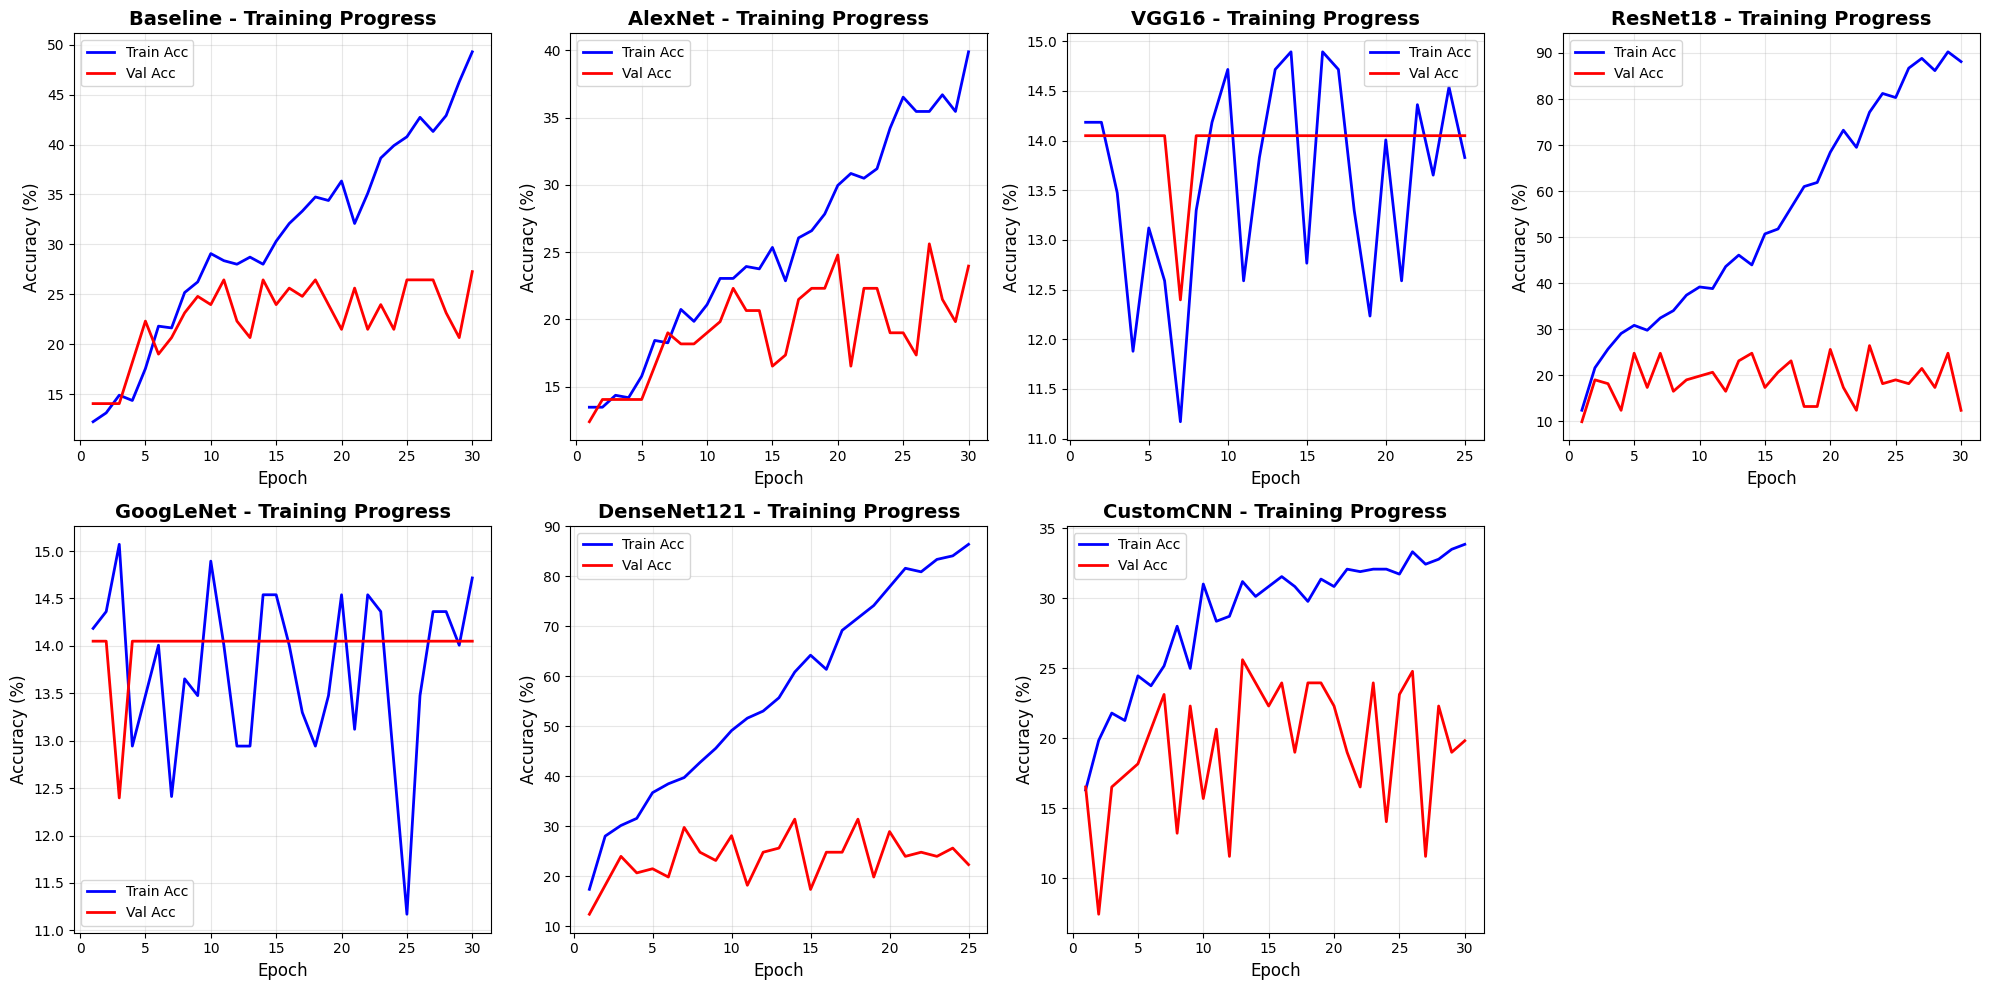

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, model_name in enumerate(results.keys()):
    ax = axes[idx]
    epochs = range(1, len(results[model_name]['train_losses']) + 1)

    ax.plot(epochs, results[model_name]['train_accs'], 'b-', label='Train Acc', linewidth=2)
    ax.plot(epochs, results[model_name]['val_accs'], 'r-', label='Val Acc', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title(f'{model_name} - Training Progress', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# fix for empty subplot
if len(results) < len(axes):
    for idx in range(len(results), len(axes)):
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

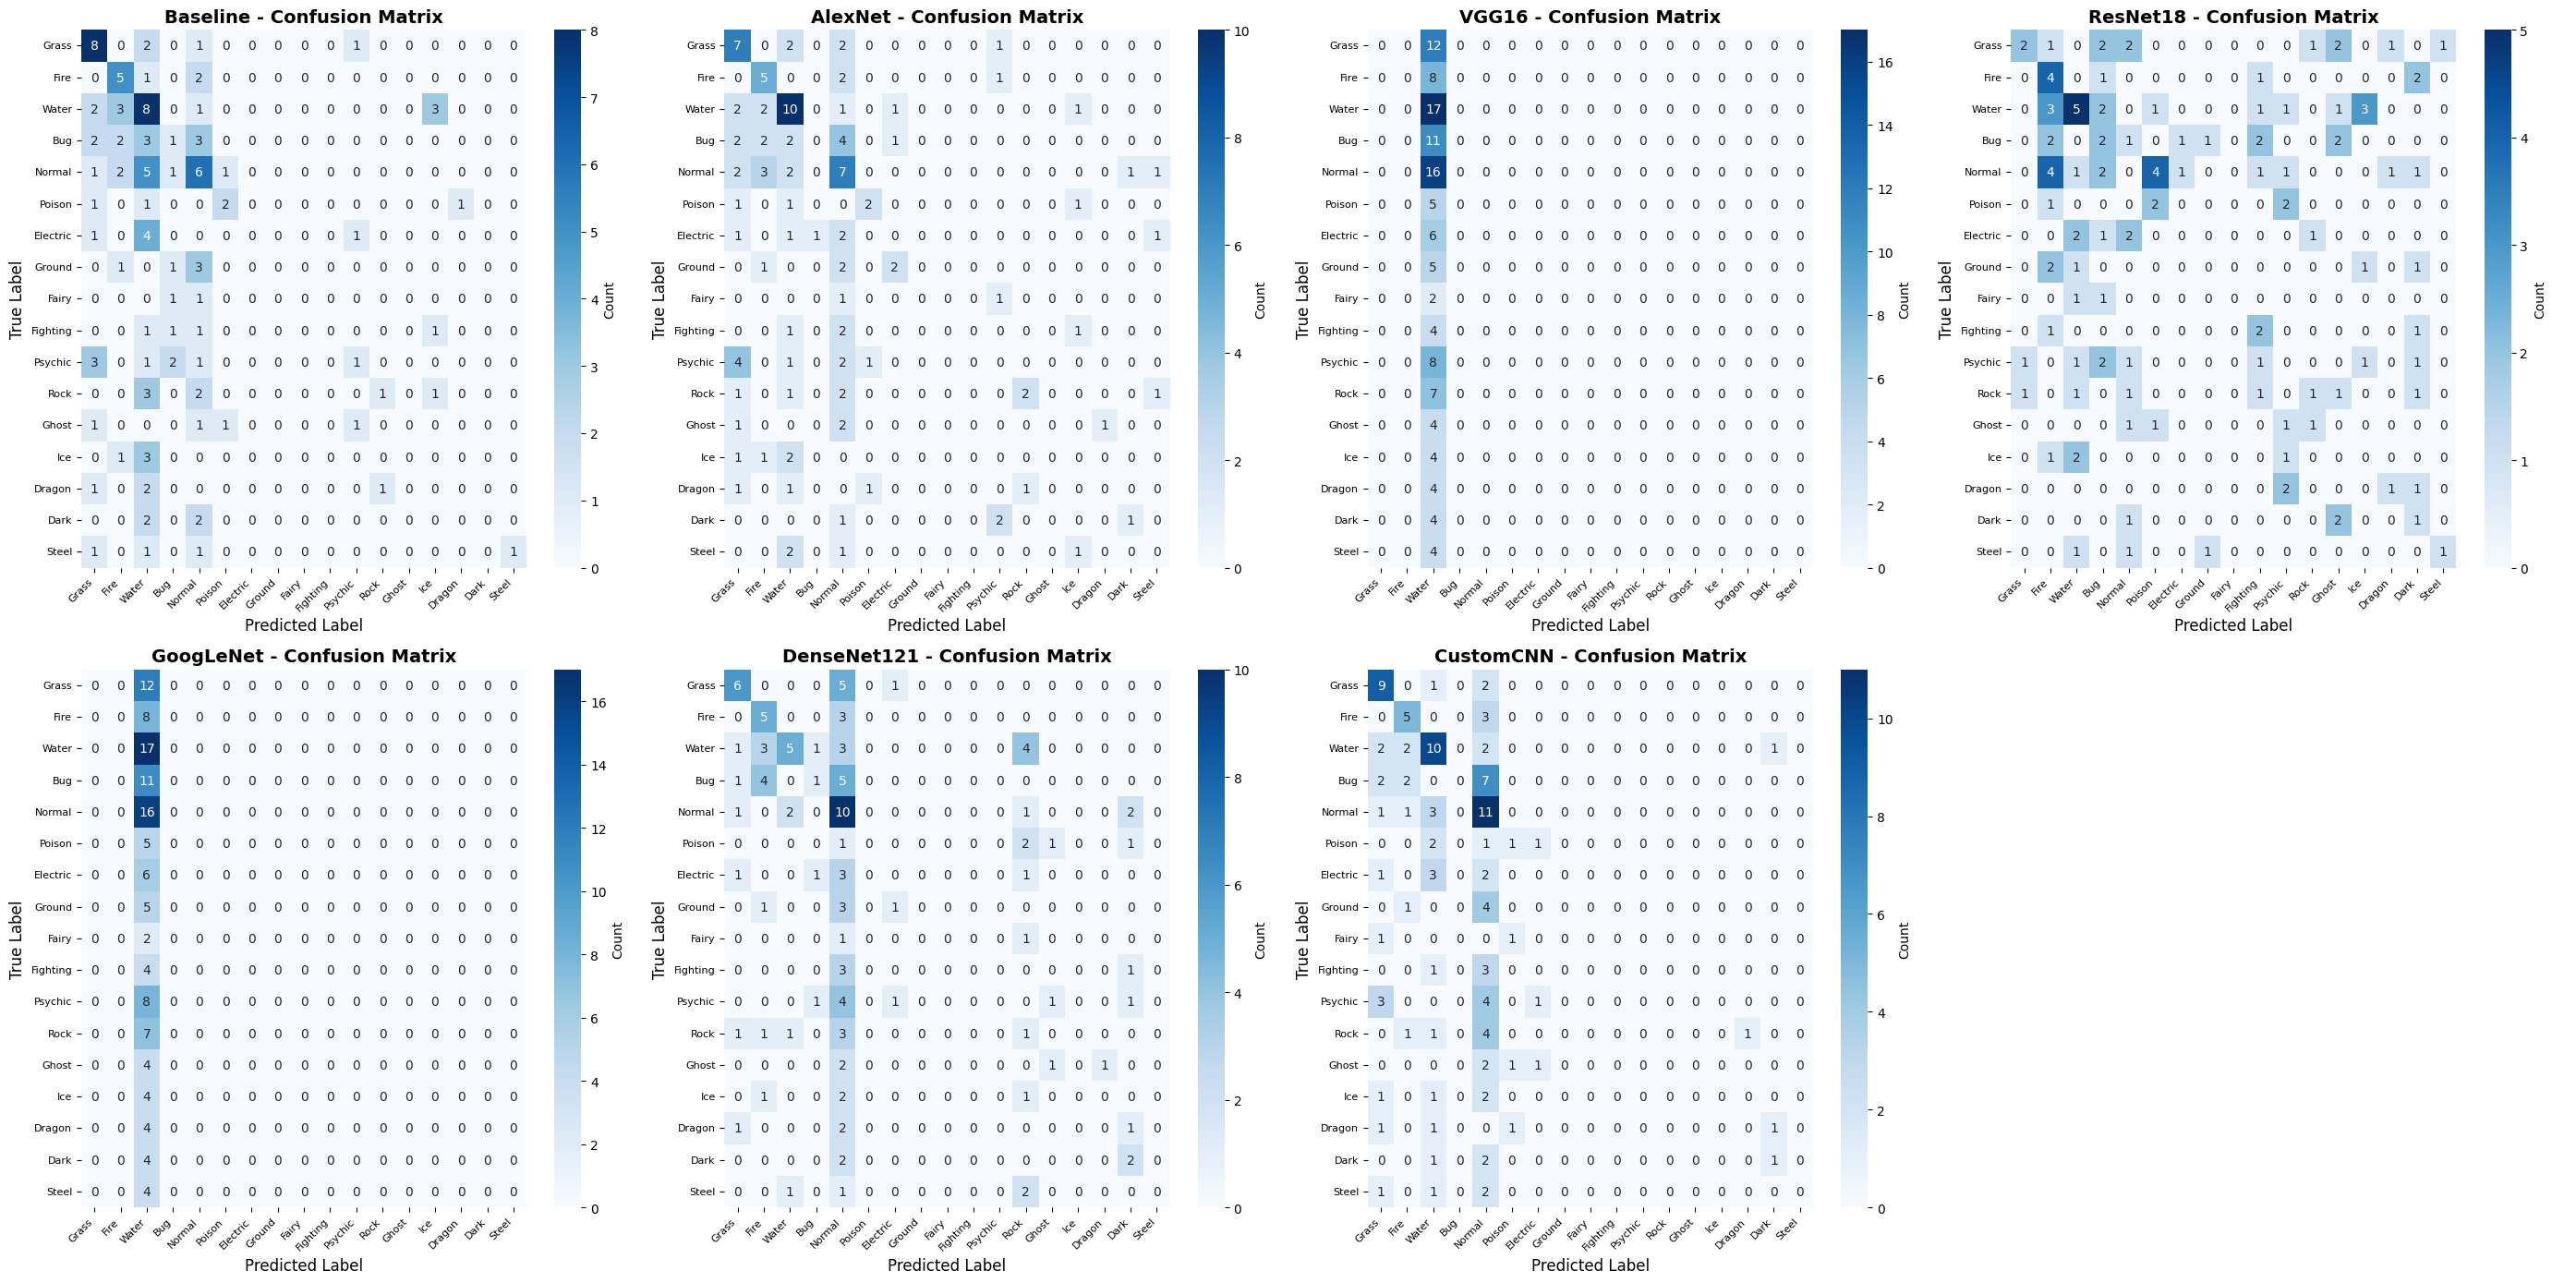

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(28, 14))
axes = axes.ravel()

# Get class names
class_names = [k for k, v in sorted(type_mapping.items(), key=lambda x: x[1])]

for idx, model_name in enumerate(results.keys()):
    ax = axes[idx]
    cm = detailed_metrics[model_name]['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

# fix for empty subplot
if len(results) < len(axes):
    for idx in range(len(results), len(axes)):
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

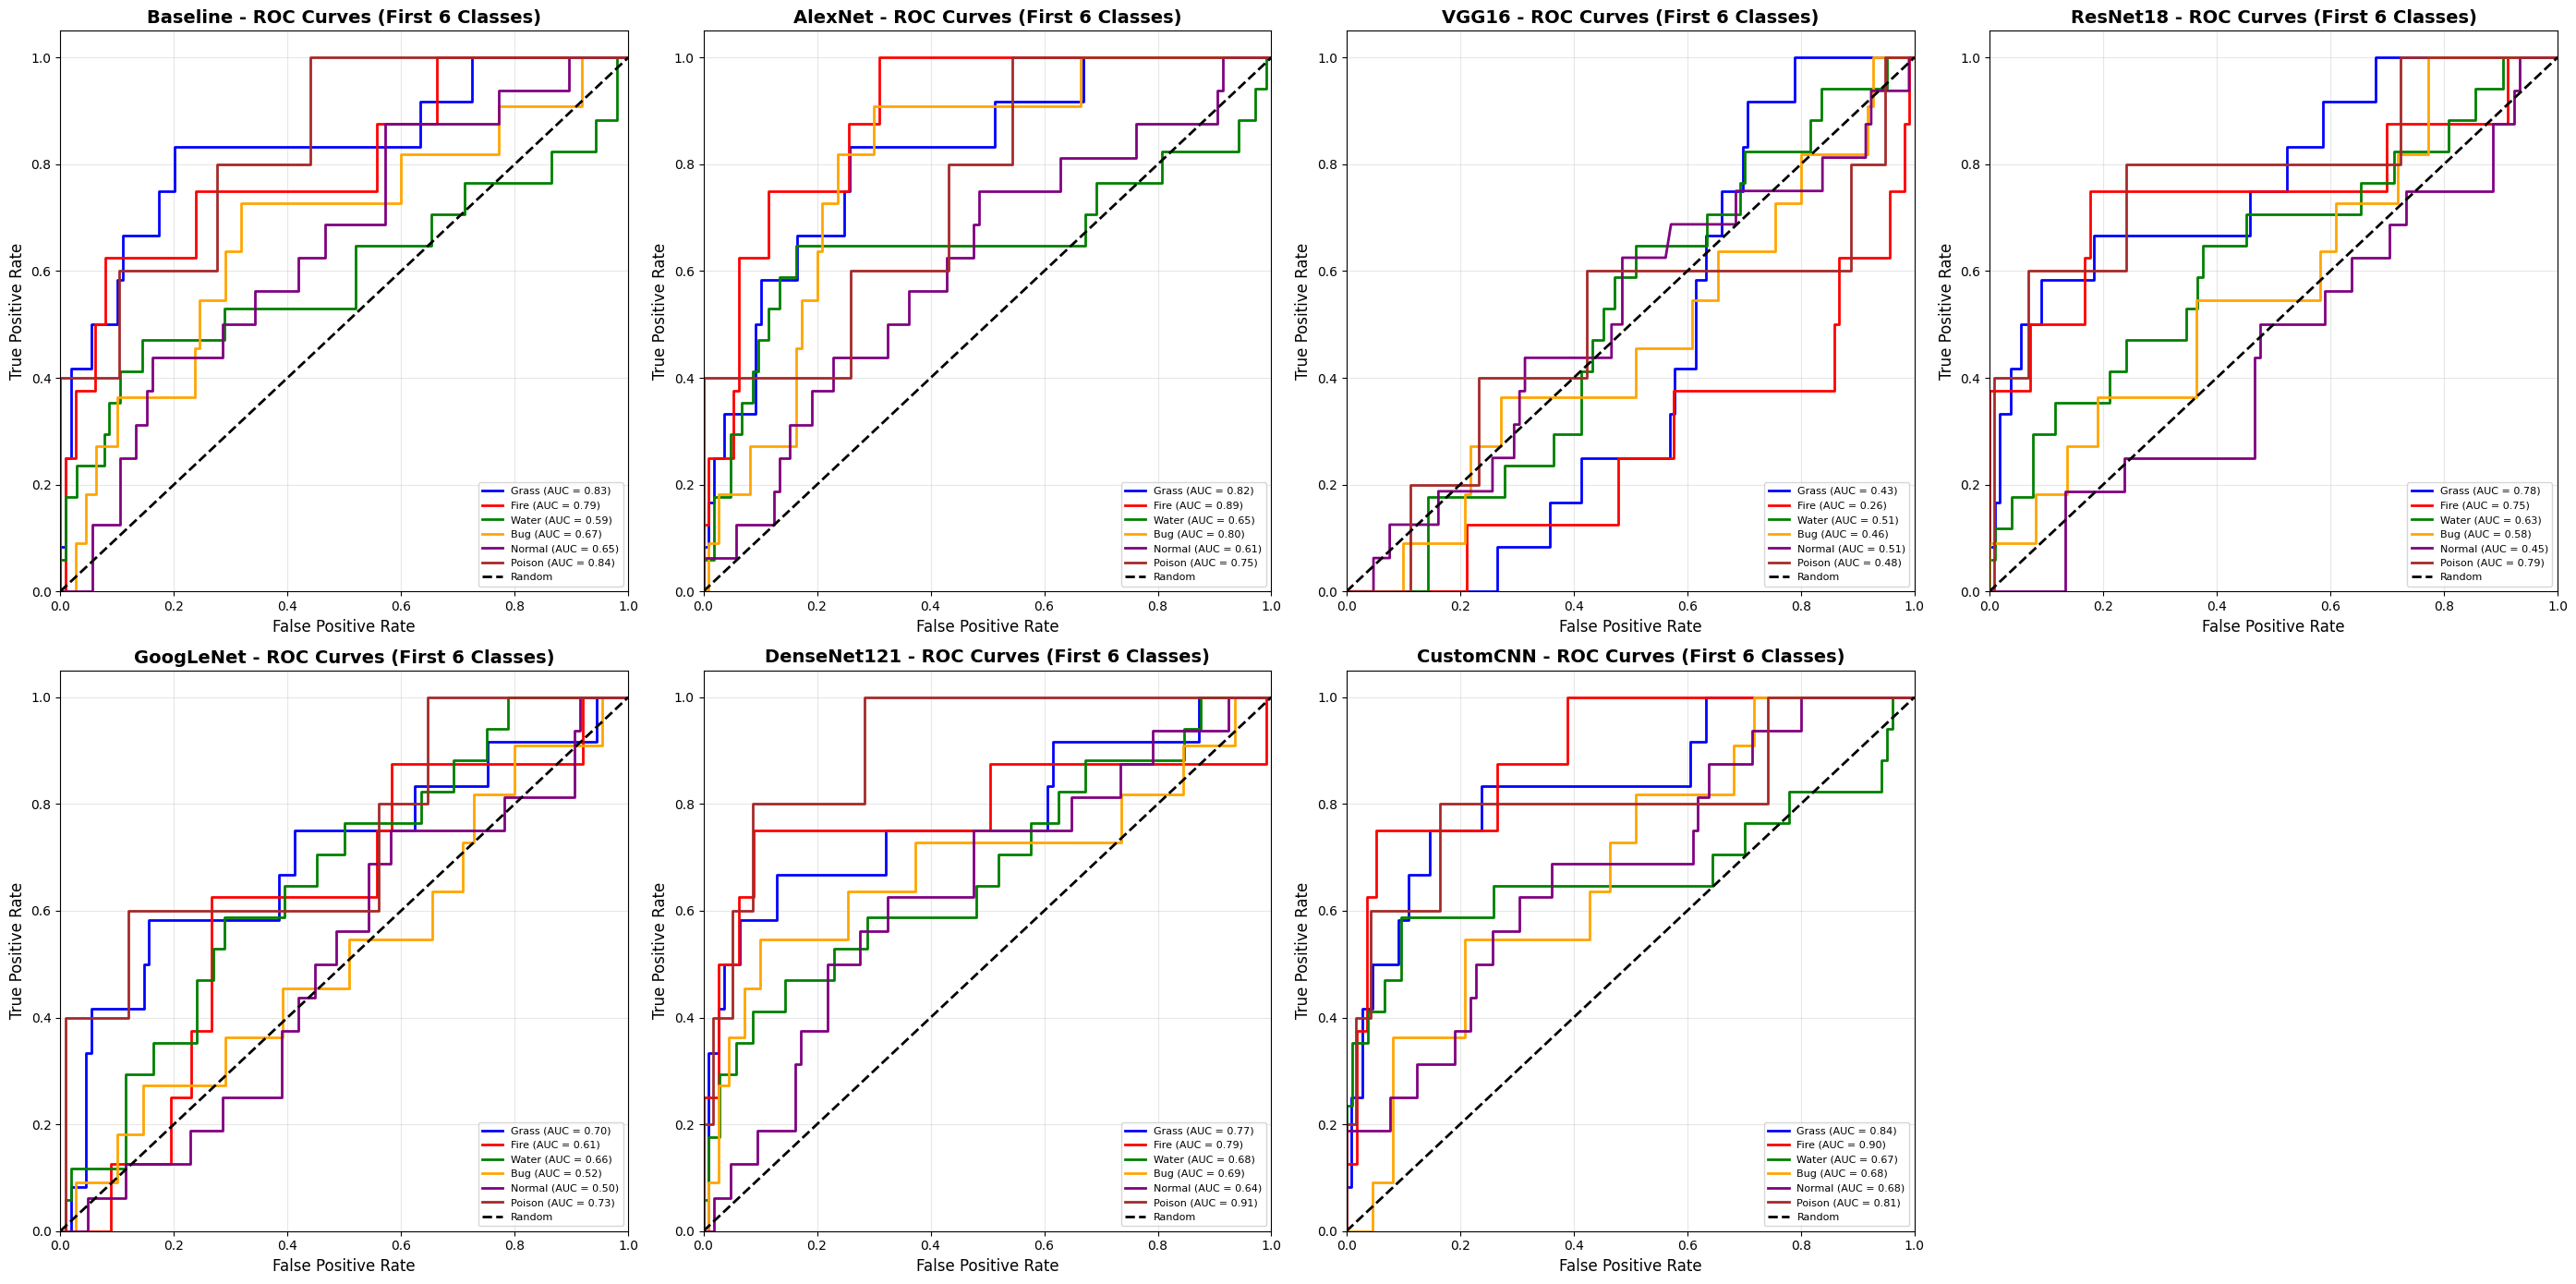

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
labels_bin = label_binarize(results['Baseline']['labels'],
                            classes=list(range(num_classes)))

fig, axes = plt.subplots(2, 4, figsize=(28, 14))
axes = axes.ravel()

for idx, model_name in enumerate(results.keys()):
    ax = axes[idx]
    probs = np.array(results[model_name]['probabilities'])

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for selected classes
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
    # Plot only first 6 classes for clarity
    for i, color in zip(range(min(6, num_classes)), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'{model_name} - ROC Curves (First 6 Classes)',
                fontsize=14, fontweight='bold')
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(True, alpha=0.3)

if len(results) < len(axes):
    for idx in range(len(results), len(axes)):
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

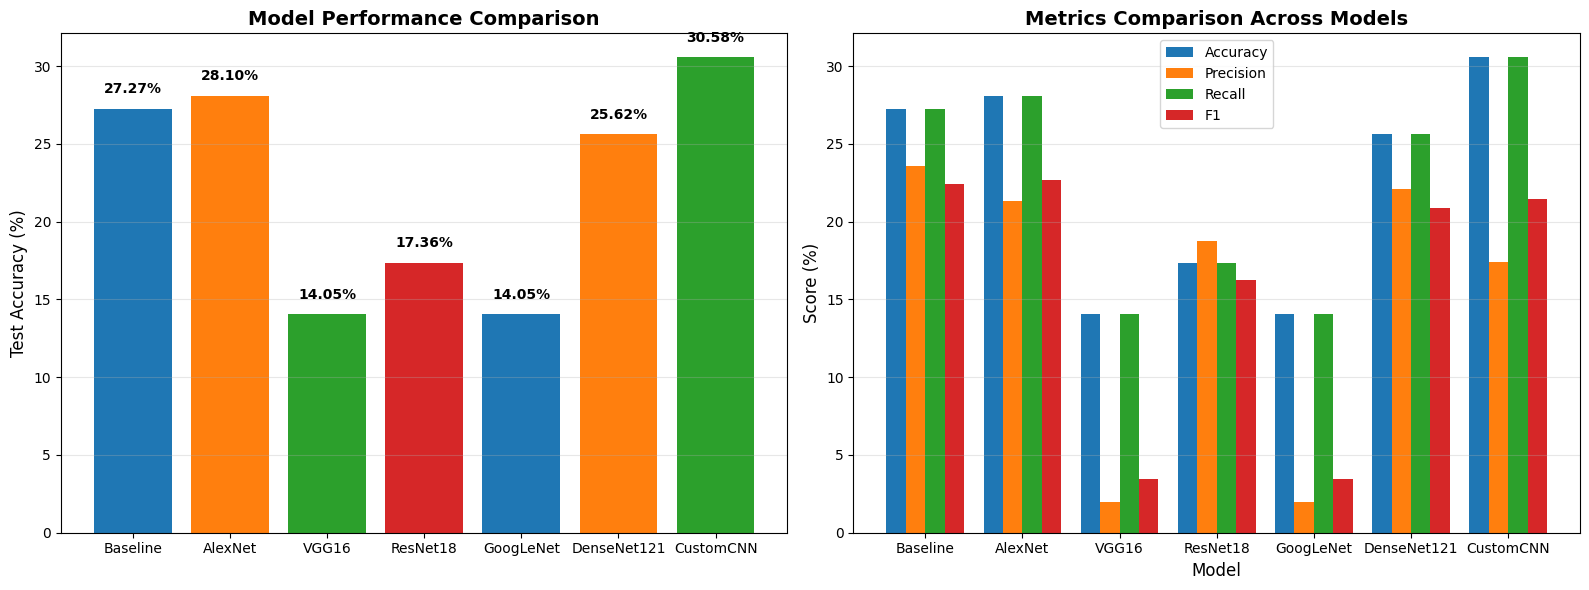

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
model_names = list(results.keys())
test_accs = [results[name]['test_acc'] for name in model_names]

axes[0].bar(model_names, test_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(test_accs):
    axes[0].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')

# Metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(model_names))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = [detailed_metrics[name][metric] for name in model_names]
    axes[1].bar(x + i*width, values, width, label=metric.capitalize())

axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Score (%)', fontsize=12)
axes[1].set_title('Metrics Comparison Across Models', fontsize=14, fontweight='bold')
axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(model_names)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*80)

for model_name in results.keys():
    config = results[model_name]['config']
    metrics = detailed_metrics[model_name]

    print(f"\n{'-'*80}")
    print(f"Model: {model_name}")
    print(f"{'-'*80}")
    print(f"\nHyperparameters:")
    print(f"  - Learning Rate: {config['lr']}")
    print(f"  - Optimizer: {config['optimizer']}")
    print(f"  - Batch Size: {config['batch_size']}")
    print(f"  - Epochs: {config['epochs']}")

    print(f"\nPerformance Metrics:")
    print(f"  - Accuracy: {metrics['accuracy']:.2f}%")
    print(f"  - Precision (weighted): {metrics['precision']:.2f}%")
    print(f"  - Recall (weighted): {metrics['recall']:.2f}%")
    print(f"  - F1-Score (weighted): {metrics['f1']:.2f}%")
    print(f"  - Mean Sensitivity: {metrics['sensitivity_per_class'].mean():.2f}%")
    print(f"  - Mean Specificity: {metrics['specificity_per_class'].mean():.2f}%")

    print(f"\nTop 5 Best Classified Types (by Recall):")
    recall_per_class = metrics['recall_per_class']
    top_5_indices = np.argsort(recall_per_class)[-5:][::-1]
    for idx in top_5_indices:
        if idx < len(class_names):
            print(f"  - {class_names[idx]}: {recall_per_class[idx]:.2f}%")

    print(f"\nTop 5 Worst Classified Types (by Recall):")
    bottom_5_indices = np.argsort(recall_per_class)[:5]
    for idx in bottom_5_indices:
        if idx < len(class_names):
            print(f"  - {class_names[idx]}: {recall_per_class[idx]:.2f}%")



COMPREHENSIVE MODEL PERFORMANCE SUMMARY

--------------------------------------------------------------------------------
Model: Baseline
--------------------------------------------------------------------------------

Hyperparameters:
  - Learning Rate: 0.001
  - Optimizer: Adam
  - Batch Size: 32
  - Epochs: 30

Performance Metrics:
  - Accuracy: 27.27%
  - Precision (weighted): 23.57%
  - Recall (weighted): 27.27%
  - F1-Score (weighted): 22.40%
  - Mean Sensitivity: 18.51%
  - Mean Specificity: 95.19%

Top 5 Best Classified Types (by Recall):
  - Grass: 66.67%
  - Fire: 62.50%
  - Water: 47.06%
  - Poison: 40.00%
  - Normal: 37.50%

Top 5 Worst Classified Types (by Recall):
  - Electric: 0.00%
  - Ground: 0.00%
  - Dark: 0.00%
  - Dragon: 0.00%
  - Ghost: 0.00%

--------------------------------------------------------------------------------
Model: AlexNet
--------------------------------------------------------------------------------

Hyperparameters:
  - Learning Rate: 0.0001


In [ ]:
# Create results dataframe
results_summary = []

for model_name in results.keys():
    metrics = detailed_metrics[model_name]
    config = results[model_name]['config']

    results_summary.append({
        'Model': model_name,
        'Learning_Rate': config['lr'],
        'Batch_Size': config['batch_size'],
        'Epochs': config['epochs'],
        'Accuracy': f"{metrics['accuracy']:.2f}",
        'Precision': f"{metrics['precision']:.2f}",
        'Recall': f"{metrics['recall']:.2f}",
        'F1_Score': f"{metrics['f1']:.2f}",
        'Mean_Sensitivity': f"{metrics['sensitivity_per_class'].mean():.2f}",
        'Mean_Specificity': f"{metrics['specificity_per_class'].mean():.2f}"
    })

results_df = pd.DataFrame(results_summary)
results_df.to_csv('model_results_summary.csv', index=False)
print("\n" + "="*80)
print("Results exported to 'model_results_summary.csv'")
print("="*80)
print("\n", results_df.to_string(index=False))


Results exported to 'model_results_summary.csv'

       Model  Learning_Rate  Batch_Size  Epochs Accuracy Precision Recall F1_Score Mean_Sensitivity Mean_Specificity
   Baseline         0.0010          32      30    27.27     23.57  27.27    22.40            18.51            95.19
    AlexNet         0.0001          32      30    28.10     21.34  28.10    22.70            18.65            95.29
      VGG16         0.0001          16      25    14.05      1.97  14.05     3.46             5.88            94.12
   ResNet18         0.0010          32      30    17.36     18.77  17.36    16.24            17.27            94.76
  GoogLeNet         0.0001          16      30    14.05      1.97  14.05     3.46             5.88            94.12
DenseNet121         0.0001          16      25    25.62     22.11  25.62    20.91            17.81            95.13
  CustomCNN         0.0010          32      30    30.58     17.42  30.58    21.45            18.24            95.39


In [ ]:
# Create detailed per-class performance table
per_class_results = []

for model_name in results.keys():
    metrics = detailed_metrics[model_name]

    for i, class_name in enumerate(class_names):
        if i < len(metrics['precision_per_class']):
            per_class_results.append({
                'Model': model_name,
                'Type': class_name,
                'Precision': f"{metrics['precision_per_class'][i]:.2f}",
                'Recall': f"{metrics['recall_per_class'][i]:.2f}",
                'Sensitivity': f"{metrics['sensitivity_per_class'][i]:.2f}",
                'Specificity': f"{metrics['specificity_per_class'][i]:.2f}"
            })

per_class_df = pd.DataFrame(per_class_results)
per_class_df.to_csv('per_class_performance.csv', index=False)
print("\nPer-class performance exported to 'per_class_performance.csv'")

# Display sample of per-class performance
print("\nSample Per-Class Performance (Baseline Model):")
baseline_classes = per_class_df[per_class_df['Model'] == 'Baseline'].head(10)
print(baseline_classes.to_string(index=False))



Per-class performance exported to 'per_class_performance.csv'

Sample Per-Class Performance (Baseline Model):
   Model     Type Precision Recall Sensitivity Specificity
Baseline    Grass     38.10  66.67       66.67       88.07
Baseline     Fire     35.71  62.50       62.50       92.04
Baseline    Water     21.62  47.06       47.06       72.12
Baseline      Bug     14.29   9.09        9.09       94.55
Baseline   Normal     24.00  37.50       37.50       81.90
Baseline   Poison     50.00  40.00       40.00       98.28
Baseline Electric      0.00   0.00        0.00      100.00
Baseline   Ground      0.00   0.00        0.00      100.00
Baseline    Fairy      0.00   0.00        0.00      100.00
Baseline Fighting      0.00   0.00        0.00      100.00


In [ ]:
# Save the best model
best_model_name = max(results.keys(), key=lambda x: results[x]['test_acc'])
print(f"\n{'='*80}")
print(f"Best Performing Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['test_acc']:.2f}%")
print(f"{'='*80}")

# Save model checkpoint
torch.save({
    'model_state_dict': trained_models[best_model_name].state_dict(),
    'model_name': best_model_name,
    'test_accuracy': results[best_model_name]['test_acc'],
    'type_mapping': type_mapping,
    'config': results[best_model_name]['config']
}, 'best_model_checkpoint.pth')

print(f"\nBest model saved as 'best_model_checkpoint.pth'")

# Save all model checkpoints
for model_name in trained_models.keys():
    torch.save({
        'model_state_dict': trained_models[model_name].state_dict(),
        'model_name': model_name,
        'test_accuracy': results[model_name]['test_acc'],
        'type_mapping': type_mapping,
        'config': results[model_name]['config']
    }, f'{model_name.lower()}_checkpoint.pth')

print("All model checkpoints saved!")

print("\n" + "="*80)
print("TRAINING AND EVALUATION COMPLETE!")
print("="*80)
print("\nGenerated Files:")
print("  1. training_curves.png - Training/validation accuracy curves")
print("  2. confusion_matrices.png - Confusion matrices for all models")
print("  3. roc_curves.png - ROC curves for all models")
print("  4. model_comparison.png - Side-by-side model comparison")
print("  5. model_results_summary.csv - Summary metrics table")
print("  6. per_class_performance.csv - Detailed per-class metrics")
print("  7. best_model_checkpoint.pth - Best performing model")
print("="*80)


Best Performing Model: CustomCNN
Test Accuracy: 30.58%

Best model saved as 'best_model_checkpoint.pth'
All model checkpoints saved!

TRAINING AND EVALUATION COMPLETE!

Generated Files:
  1. training_curves.png - Training/validation accuracy curves
  2. confusion_matrices.png - Confusion matrices for all models
  3. roc_curves.png - ROC curves for all models
  4. model_comparison.png - Side-by-side model comparison
  5. model_results_summary.csv - Summary metrics table
  6. per_class_performance.csv - Detailed per-class metrics
  7. best_model_checkpoint.pth - Best performing model
  8. Individual model checkpoints for each architecture
